<a href="https://colab.research.google.com/github/dzailz/MFoML/blob/main/Katin_V_V_Practice_3_'Cars_Moldova'_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_moons, make_circles

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

from sklearn.metrics import classification_report

from sklearn.preprocessing import MinMaxScaler

# Вспомогательные функции

In [2]:
from random import choice
def random_color() -> str:
    return "#" + "".join([choice('0123456789ABCDEF') for j in range(6)])

In [3]:
from typing import Any
from pandas.core.api import DataFrame
def pd_read_csv(file: Any, delimiter: str = ",") -> DataFrame:
    return pd.read_csv(file, delimiter = delimiter)

In [4]:
def conf_matrix(y_test, y_predict):
    """Функция матрицы несоответствий"""
    c_matrix = confusion_matrix(y_test, y_predict)
    TN = c_matrix[0, 0]
    TP = c_matrix[1, 1]
    FN = c_matrix[1, 0]
    FP = c_matrix[0, 1]

    print(f"""Истинно-отрицательные результаты:   {TN}
Истинно-положительные результаты:  {TP}
Ложно-положительные результаты: {FP}
Ложно-отрицательные результаты: {FN}

Доля правильных ответов алгоритма:  {round((TP + TN) / float(TP + TN +FP + FN), 3)}
Точность: {round(TP / float(TP + FP), 3)}
Полнота:    {round(TP / float(TP + FN), 3)}
Специфичность: {round(TN / float(TN + FP), 3)}
Отрицательные:  {round(TN / float(TN + FN), 3)}""")

In [5]:
def roc_auc(y_test, y_predict, dens=True):
    probs = y_predict

    false, true, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    fig, ax = plt.subplots(figsize=(7,7))
    plt.plot([0, 1], label="Случайное предположение", linestyle="--", color=random_color())
    plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=":", color=random_color(), label = "Идеальный результат")
    plt.plot(false, true, label="ROC-AUC", color=random_color())
    ax.set_title("ROC-кривая = %0.3f"%roc_auc)
    plt.ylabel("Истинный положительный показатель")
    plt.xlabel("Ложно-положительный показатель")
    plt.legend(loc='lower right')
    plt.show()

# Логистическая регрессия

### Выгрузим с гитхаба ранее сохраненые данные и проверим отсутсвие типа object

In [6]:
df = pd_read_csv("https://raw.githubusercontent.com/dzailz/MFoML/main/cars_moldova_num.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32595 entries, 0 to 32594
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  32595 non-null  int64  
 1   Model                 32595 non-null  int64  
 2   Year                  32595 non-null  int64  
 3   Style                 32595 non-null  int64  
 4   Distance              32595 non-null  float64
 5   Engine_capacity(cm3)  32595 non-null  float64
 6   Fuel_type             32595 non-null  int64  
 7   Transmission          32595 non-null  int64  
 8   Price(euro)           32595 non-null  float64
 9   Age                   32595 non-null  int64  
 10  km_year               32595 non-null  float64
 11  price/km              32595 non-null  float64
 12  luxury                32595 non-null  int64  
 13  eco                   32595 non-null  int64  
 14  relative_age          32595 non-null  int64  
dtypes: float64(5), int6

### Разобьем данные по типам

In [7]:
df.sample(10)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,price/km,luxury,eco,relative_age
14985,29,102,2012,10,188500.0,2000.0,2,0,10300.0,10,18850.000000,0.054642,0,1,0
19899,34,86,2013,10,144000.0,1800.0,4,0,10600.0,9,16000.000000,0.073611,0,0,0
24446,17,102,2000,3,320000.0,3100.0,0,0,2500.0,22,14545.454545,0.007812,0,0,1
22903,38,102,2004,11,250000.0,1400.0,0,1,2650.0,18,13888.888889,0.010600,0,0,1
24210,25,72,2008,10,164353.0,1584.0,4,1,5000.0,14,11739.500000,0.030422,0,0,1
16884,14,122,2006,3,272121.0,2000.0,3,1,5650.0,16,17007.562500,0.020763,0,0,1
26810,34,102,2009,6,185000.0,1200.0,3,1,4300.0,13,14230.769231,0.023243,0,0,1
31288,2,131,2008,3,345000.0,3000.0,0,0,13500.0,14,24642.857143,0.039130,1,0,1
22525,42,91,2000,11,282205.0,1422.0,0,1,2200.0,22,12827.500000,0.007796,0,0,1
293,34,115,2014,10,202300.0,1598.0,0,0,13199.0,8,25287.500000,0.065245,0,0,0


In [8]:
cat_columns = ["Make", "Model", "Style", "Fuel_type", "Transmission", "luxury", "eco", "relative_age"]
num_columns = ["Year", "Distance", "Engine_capacity(cm3)", "Price(euro)", "km_year", "price/km"]

### Разобьем на тестовую и тренировочную выборку только числовые данные 

In [9]:
X = df[num_columns].copy()
y = df["Transmission"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

Создаем модель на основе логистической регрессии

In [10]:
log_r = LogisticRegression(fit_intercept=True, penalty='l2', solver='saga', C=1, max_iter=100000)
log_r.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=100000, solver='saga')

In [11]:
y_predict = log_r.predict(X_test)

Смотрим что получилось

In [12]:
print(classification_report(y_test, y_predict, target_names=['Manual','Auto']))

              precision    recall  f1-score   support

      Manual       0.82      0.72      0.76      4432
        Auto       0.79      0.87      0.83      5347

    accuracy                           0.80      9779
   macro avg       0.80      0.79      0.79      9779
weighted avg       0.80      0.80      0.80      9779



In [13]:
print('Test score: {:.4f}'.format(log_r.score(X_test, y_test)))
print('Train score: {:.4f}'.format(log_r.score(X_train, y_train)))

Test score: 0.7988
Train score: 0.7986


In [14]:
conf_matrix(y_test, y_predict)

Истинно-отрицательные результаты:   3169
Истинно-положительные результаты:  4642
Ложно-положительные результаты: 1263
Ложно-отрицательные результаты: 705

Доля правильных ответов алгоритма:  0.799
Точность: 0.786
Полнота:    0.868
Специфичность: 0.715
Отрицательные:  0.818


Показатели приведеные выше говорят о том, что модель не идеальна, но и не очень плоха

<Figure size 432x288 with 0 Axes>

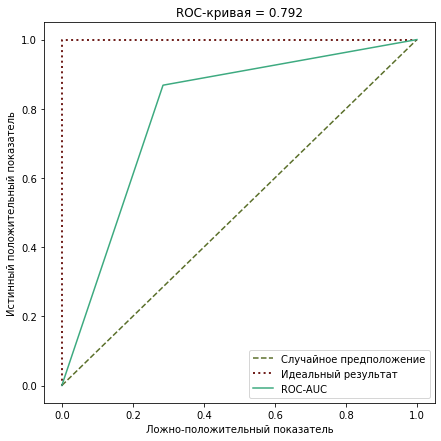

In [15]:
roc_auc(y_test, y_predict)

График ROC-кривой показывает площадь под кривой - 0,792.

# Стандартизированные данные

## Посмотрим как поведет себя модель логистической регрессии на основе стандартизированных данных.

### Скачиваем с github таблицу со стандартизированными данными

In [16]:
df_std = pd_read_csv("https://raw.githubusercontent.com/dzailz/MFoML/main/cars_moldova_stand.csv")
df_std[num_columns].head(5)

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,price/km
0,0.371579,0.137604,-0.073059,-0.180885,0.384365,-0.051813
1,0.787743,-0.480459,-0.543659,-0.097067,0.268438,-0.045889
2,0.510300,-0.737985,-0.543659,-0.306611,-0.530687,-0.046840
3,-0.322027,0.189109,-0.386793,-0.563301,-0.326655,-0.056645
4,-1.154355,1.219213,0.554408,-0.627212,-0.172085,-0.058872


### Добавим категориальный столбец с КПП

In [17]:
transmission_type = {"Manual": 0, "Automatic": 1}
df_std["Transmission_num"] = df_std["Transmission"].map(transmission_type)

### Разобьем на тестовую и тренировочную выборку

In [18]:
X = df_std[num_columns].values 
y = df_std["Transmission_num"].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

### Создаем модель

In [19]:
log_std = LogisticRegression(fit_intercept=True, penalty="l2", solver="saga", C=1, max_iter=100000)
log_std.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=100000, solver='saga')

In [20]:
y_predict = log_std.predict(X_test)

In [21]:
print(classification_report(y_test, y_predict, target_names=["Manual","Auto"]))

              precision    recall  f1-score   support

      Manual       0.80      0.87      0.83      4473
        Auto       0.82      0.74      0.78      3676

    accuracy                           0.81      8149
   macro avg       0.81      0.80      0.81      8149
weighted avg       0.81      0.81      0.81      8149



In [22]:
print("Test score: {:.4f}".format(log_std.score(X_test, y_test)))
print("Train score: {:.4f}".format(log_std.score(X_train, y_train)))

Test score: 0.8098
Train score: 0.8059


In [23]:
conf_matrix(y_test, y_predict)

Истинно-отрицательные результаты:   3883
Истинно-положительные результаты:  2716
Ложно-положительные результаты: 590
Ложно-отрицательные результаты: 960

Доля правильных ответов алгоритма:  0.81
Точность: 0.822
Полнота:    0.739
Специфичность: 0.868
Отрицательные:  0.802


Баланс результатов был бы не плох если бы не просевшая полнота

<Figure size 432x288 with 0 Axes>

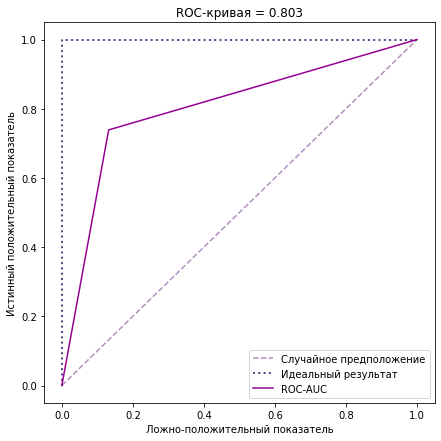

In [24]:
roc_auc(y_test, y_predict)

Судя по графику - результат незначительно улучшился

# Нормализованные данные

### Скачиваем сохраненную таблицу со стандартизированными данными

In [25]:
df_norm = pd_read_csv("https://raw.githubusercontent.com/dzailz/MFoML/main/cars_moldova_norm.csv")
df_norm.drop(columns="Age")
df_norm[num_columns].head(5)

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,price/km
0,0.80,0.194919,0.36,0.075651,0.353252,0.039744
1,0.86,0.134913,0.30,0.083667,0.336172,0.063333
2,0.82,0.109911,0.30,0.063627,0.218437,0.059545
3,0.70,0.199920,0.32,0.039078,0.248497,0.020500
4,0.58,0.299930,0.44,0.032966,0.271270,0.011633


In [26]:
transm = {"Manual": 0, "Automatic": 1}
df_norm["Transmission_num"] = df_norm["Transmission"].map(transm)

In [27]:
df_norm.head(10)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,price/km,luxury,eco,relative_age,Transmission_num
0,Toyota,Prius,0.80,Hatchback,0.194919,0.360,Hybrid,Automatic,0.075651,0.20,0.353252,0.039744,no,yes,old,1
1,Renault,Grand Scenic,0.86,Universal,0.134913,0.300,Diesel,Manual,0.083667,0.14,0.336172,0.063333,no,no,kind_old,0
2,Renault,Laguna,0.82,Universal,0.109911,0.300,Diesel,Manual,0.063627,0.18,0.218437,0.059545,no,no,kind_old,0
3,Opel,Astra,0.70,Universal,0.199920,0.320,Metan/Propan,Manual,0.039078,0.30,0.248497,0.020500,no,no,old,0
4,Mercedes,Vito,0.58,Microvan,0.299930,0.440,Diesel,Manual,0.032966,0.42,0.271270,0.011633,no,no,old,0
5,Volkswagen,Passat,0.78,Universal,0.289929,0.278,Petrol,Manual,0.054108,0.22,0.482298,0.019310,no,no,old,0
6,Volkswagen,Touareg,0.78,SUV,0.219922,0.480,Diesel,Automatic,0.168337,0.22,0.365397,0.077273,yes,no,old,1
7,Mercedes,Series (W124),0.40,Sedan,0.239924,0.460,Petrol,Manual,0.026553,0.60,0.153145,0.011875,no,no,old,0
8,BMW,5 Series,0.66,Sedan,0.324932,0.060,Diesel,Manual,0.032064,0.34,0.359831,0.010462,no,no,old,0
9,Mercedes,E Class,0.78,Sedan,0.209921,0.440,Diesel,Automatic,0.112224,0.22,0.348697,0.054286,no,no,old,1


In [28]:
X = df_norm[num_columns].values 
y = df_norm["Transmission_num"].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

### Создим модель

In [29]:
# Создаем модель
log_norm = LogisticRegression(fit_intercept=True, penalty="l2", solver="saga", C=1, max_iter=100000)
log_norm.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=100000, solver='saga')

In [30]:
y_predict = log_norm.predict(X_test)

### Результаты

In [31]:
print (classification_report(y_test, y_predict, target_names=["Manual","Auto"]))

              precision    recall  f1-score   support

      Manual       0.79      0.85      0.82      5347
        Auto       0.81      0.73      0.77      4432

    accuracy                           0.80      9779
   macro avg       0.80      0.79      0.80      9779
weighted avg       0.80      0.80      0.80      9779



In [32]:
print('Test score: {:.4f}'.format(log_norm.score(X_test, y_test)))
print('Train score: {:.4f}'.format(log_norm.score(X_train, y_train)))

Test score: 0.7991
Train score: 0.8008


In [33]:
conf_matrix(y_test, y_predict)

Истинно-отрицательные результаты:   4568
Истинно-положительные результаты:  3246
Ложно-положительные результаты: 779
Ложно-отрицательные результаты: 1186

Доля правильных ответов алгоритма:  0.799
Точность: 0.806
Полнота:    0.732
Специфичность: 0.854
Отрицательные:  0.794


Баланс результатов практически тот же. 

<Figure size 432x288 with 0 Axes>

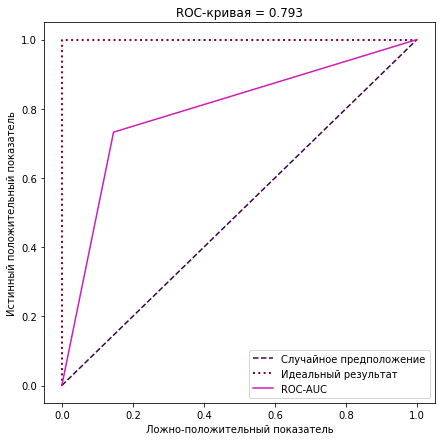

In [34]:
roc_auc(y_test, y_predict);

График кривой ROC показал площадь под кривой - 0,804, что практически не отличается от стандартизации.

# One-hot encoding

### Скачиваем таблицу с данными закодированы OneHotEncoding

In [35]:
df_ohe = pd_read_csv("https://raw.githubusercontent.com/dzailz/MFoML/main/cars_moldova_onehot.csv")
df_ohe.drop(columns = "Age")

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year,price/km,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,...,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Automatic,Transmission_Manual,luxury_no,luxury_yes,eco_no,eco_yes,relative_age_kind_old,relative_age_old
0,2011,195000.0,1800.0,7750.0,17727.272727,0.039744,0,0,0,0,...,0,0,1,0,1,0,0,1,0,1
1,2014,135000.0,1500.0,8550.0,16875.000000,0.063333,0,0,0,0,...,0,0,0,1,1,0,1,0,1,0
2,2012,110000.0,1500.0,6550.0,11000.000000,0.059545,0,0,0,0,...,0,0,0,1,1,0,1,0,1,0
3,2006,200000.0,1600.0,4100.0,12500.000000,0.020500,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
4,2000,300000.0,2200.0,3490.0,13636.363636,0.011633,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32590,2016,88000.0,1800.0,11500.0,14666.666667,0.130682,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
32591,2002,225000.0,1800.0,4400.0,11250.000000,0.019556,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
32592,2015,89000.0,1500.0,7000.0,12714.285714,0.078652,0,0,0,0,...,0,0,0,1,1,0,1,0,1,0
32593,2006,370000.0,2000.0,4000.0,23125.000000,0.010811,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1


In [36]:
X = df_ohe.drop(columns = ["Transmission_Automatic", "Transmission_Manual"])
y = df_norm["Transmission_num"] # Возьмем числовые данные по трансмиссии из датафрейма с нормализованными данными.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,204,205,206,207,208,209,210,211,212,213
22811,0.68,0.144914,0.36,0.029574,0.32,0.168926,0.000063,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
22812,0.76,0.249925,0.26,0.040602,0.24,0.383382,0.000049,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
22813,0.42,0.249925,0.38,0.019549,0.58,0.164997,0.000025,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
22814,0.74,0.260926,0.44,0.109774,0.26,0.371600,0.000124,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
22815,0.76,0.204356,0.28,0.067659,0.24,0.313143,0.000099,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Создаем модель One Hot Encoding

In [37]:
log_ohe= LogisticRegression(fit_intercept=True, penalty="l2", solver="saga", C=1, max_iter=100000)
log_ohe.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=100000, solver='saga')

In [38]:
y_predict = log_ohe.predict(X_test)

In [39]:
print(classification_report(y_test, y_predict, target_names=["Manual", "Automatic"]))

              precision    recall  f1-score   support

      Manual       0.85      0.89      0.87      5347
   Automatic       0.86      0.81      0.83      4432

    accuracy                           0.85      9779
   macro avg       0.86      0.85      0.85      9779
weighted avg       0.85      0.85      0.85      9779



In [40]:
print('Test score: {:.4f}'.format(log_ohe.score(X_test, y_test)))
print('Train score: {:.4f}'.format(log_ohe.score(X_train, y_train)))

Test score: 0.8540
Train score: 0.8570


In [41]:
conf_matrix(y_test, y_predict)

Истинно-отрицательные результаты:   4776
Истинно-положительные результаты:  3575
Ложно-положительные результаты: 571
Ложно-отрицательные результаты: 857

Доля правильных ответов алгоритма:  0.854
Точность: 0.862
Полнота:    0.807
Специфичность: 0.893
Отрицательные:  0.848


Все показатели лучше, чем в прошлых тестах.

<Figure size 432x288 with 0 Axes>

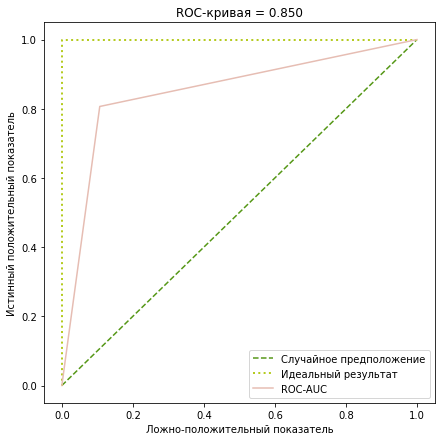

In [42]:
roc_auc(y_test, y_predict);

График ROC-кривой показал наилучший результат всех тестов.

# Выводы:

One Hot Encoding - Лучше всего подходит для применения вмсете с логиситческой регрессией